<a href="https://colab.research.google.com/github/kdidi99/Python_for_Biochemists/blob/main/cvae-cross-feedback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 4

## Preliminaries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    

batch_size = 128

# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

0.0%

100.0%


Extracting ./mnist_data/MNIST\raw\train-images-idx3-ubyte.gz to ./mnist_data/MNIST\raw


102.8%


2.5%

Extracting ./mnist_data/MNIST\raw\train-labels-idx1-ubyte.gz to ./mnist_data/MNIST\raw



100.0%


Extracting ./mnist_data/MNIST\raw\t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST\raw



112.7%

Extracting ./mnist_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST\raw



In [ ]:
#Converts label idx (n labels total) into one-hot encoding
def idx2onehot(idx, n):

    assert torch.max(idx).item() < n
    if idx.dim() == 1:
        idx = idx.unsqueeze(1)

    onehot = torch.zeros(idx.size(0), n)
    onehot.scatter_(1, idx, 1)

    return onehot

#example:
idx2onehot(3*torch.ones(7, dtype=torch.long),n=10)

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

## Basics/Repetition  of VAE

In the lecture we have shown that $$\log p^*(x^{(i)}) \ge  -  D_{KL}[p_E(z \mid x^{(i)}) \| p(z)] +\mathbb{E}_{z\sim p_E(z \mid x^{(i)})} [\log p_D (x^{(i)} \mid z)] = -\mathcal{L}(D, E, x^{(i)}),$$
where $x^{(i)}\in\mathbb{R}^D$ is the $i$-th training instance (since the pixel values of MNIST images are in the range 0...1, we even have $x^{(i)}\in[0,1]^D$ in this case). The LHS is the logarithm of the true data distribution, and the RHS is termed the "evicence lower bound" (ELBO).

We call $p_E(z \mid x)$ the encoder and $p_D( x \mid z)$ the decoder. Both will be represented by neural networks. Our goal is to approximate $p^*(x)$ as well as possible by maximizing the ELBO or equivalently minimizing its negation. Specifically, we minimize $\mathcal{L}(D, E, x^{(i)})$ with respect to the parameters of the decoder network $D$ and the encoder network $E$ via gradient descent over all training instances $i$. 

In order to estimate the negative ELBO, we approximate the expectation w.r.t. $z$ by its average over $L$ instances:
\begin{align} \hat{\mathcal{L}}(D, E, x^{(i)}) = D_{KL}\left[p_E(z \mid x^{(i)}) \| p(z)\right]+ \frac{1}{L} \sum_{l=1}^L \left(-\log p_D(x^{(i)} \mid z^{(i,l)})\right)\end{align} 
where $z^{(i,l)} \sim p_E(z \mid x^{(i)}) $. By construction of a VAE, $p_E(z \mid x^{(i)})$ is a Gaussian distribution whose mean $\mu^{(i)}=\mu_E(x^{(i)})$ and standard deviation $\sigma^{(i)}=\sigma_E(x^{(i)})$ are computed by the encoder network. For fixed $x^{(i)}$, we can draw samples $z^{(i,l)}$ from this code distribution by means of the reparametrization trick: 
$$z^{(i,l)}\sim \mathcal{N}\big(\mu^{(i)}, \text{diag}(\sigma^{(i)})^2\big) \Leftrightarrow  z^{(i,l)} = \mu^{(i)} + \epsilon_l \cdot \sigma^{(i)}$$ 
with $\epsilon_l\sim\mathcal{N}(0, \mathbb{I})$. Note that $\mu^{(i)}$, $\sigma^{(i)}$, and $\epsilon_l$ are vectors of length equal to the dimension $J$ of the latent space, and $\epsilon_l \cdot \sigma^{(i)}$ is element-wise multiplication. In practice, $L=1$ is usually sufficient so that the average over index $l$ becomes trivial.

Furthermore, we assume that the latent prior is a standard normal distribution, i.e. $p(z) = \mathcal{N}(0, \mathbb{I})$. The KL-term for the two multivariate normal distributions can then be computed analytically:
$$ D_{KL}\left[p_E(z \mid x^{(i)}) \| p(z)\right] = \frac{1}{2} \sum_{j=1}^J \left((\mu_j^{(i)})^2 + (\sigma_j^{(i)})^2 - 2 \log(\sigma_j^{(i)}) - 1\right) $$

Likewise, we consider $p_D(x \mid z)$ as a Gaussian distribution with mean $\mu_D(z)$ and fixed covariance matrix $\sigma_G^2\cdot \mathbb{I}$ (i.e. $\sigma_G$ is the fixed noise standard deviation):
$$ p_G(x \mid z) = \mathcal{N}\big(\mu_D(z), \sigma_G^2\cdot\mathbb{I}\big)$$
To ensure that $\mu_D(z) \in [0,1]^D$ holds for reconstructed images (without noise), the decoder's output layer should use the sigmoid activation function. The second term in the negated ELBO (the negative log-likelihood) now reduces to the squared loss:
$$-\log p_D(x^{(i)} \mid z^{(i,l)}) = \frac{||x^{(i)} - \mu_D(z^{(i,l)})||^2_2}{2 \sigma_G^2}  + \text{const.}$$
The additive constant has no influence on the training optimimum and can be dropped. $\sigma_G$ can be used as a hyperparameter to balance the two loss terms.

For a batch of samples $X = (x^{(1)}, \dots, x^{(M)})$, we finally get the negated ELBO as:
\begin{align} -ELBO = \sum_{i=1}^M \Big[&\frac{1}{2} \sum_{j=1}^J \left((\mu_j^{(i)})^2 + (\sigma_j^{(i)})^2 - 2 \log(\sigma_j^{(i)}) - 1\right) \\+& \frac{1}{L} \sum_{l=1}^L \sum_{j=1}^D \frac{(x^{(i)}_j - \mu_D(z^{(i,l)})_j)^2}{2\sigma_G^2}\Big]\end{align}
Training is performed by gradient descent on this loss.

## Task 1: Implementation of VAE and CVAE

Complete the code below. The CVAE class consists of three parts
* The Encoder class that implements $p_E (z \mid x, y)$,
* The Decoder class which implements $p_D (x \mid z, y)$ and
* The actual CVAE class that combines both encoder and decoder.

The conditioning variable $y$ holds the labels, e.g. 0...9 for MNIST digits. It is added as an additional network input, i.e. the encoder computes $\mu_E(x^{(i)}, y^{(i)})$ and $\sigma_E(x^{(i)}, y^{(i)})$. The decoder produces the reconstruction `recon_x`=$\mu_D(z^{(i)}, y^{(i)})$, where $z^{(i)}$ is sampled using the reparametrization trick explained above. 

Implement all three classes. The arguments and outputs for each method are given in the docstrings. Make sure the CVAE class implements both the conditional VAE (CVAE) and the plain VAE, where the latter is obtained if the number of labels is just 1. 

In [ ]:
class CVAE(nn.Module):

    def __init__(self, inp_dim, encoder_layer_sizes, decoder_layer_sizes, latent_dim, num_labels=10, conditional=False):
        """
        Arguments:
            inp_dim (int): dimension of input,
            encoder_layer_sizes (list[int]): list of the sizes of the encoder layers,
            decoder_layer_sizes (list[int]): list of the sizes of the decoder layers,
            latent_dim (int): dimension of latent space/bottleneck,
            num_labels (int): amount of labels (important for conditional VAE),,
            conditional (bool): True if CVAE, else False

        """
        
        super(CVAE, self).__init__()
        
        self.latent_dim = latent_dim
        self.num_labels = num_labels
        
        self.encoder = Encoder(encoder_layer_sizes, latent_dim, num_labels, conditional)
        self.decoder = Decoder(decoder_layer_sizes, latent_dim, num_labels, conditional)
        
    def forward(self, x, c=None):
        """
        Forward Process of whole VAE/CVAE. 
        Arguments:
            x: tensor of dimension (batch_size, 1, 28, 28) or (batch_size, 28*28)
            c: None or tensor of dimension (batch_size, 1)
        Output: recon_x, means, log_var
            recon_x: see explanation on second part of estimator above,
            means: output of encoder,
            log_var: output of encoder (logarithm of variance)
        """
        batch_size = x.size(0)

        x = x.view(-1,784)
        
        ################################
        # TODO: YOUR CODE STARTS BELOW #
        ################################

        code_means, code_log_vars = self.encoder.forward(x, c)

        code_eps = torch.randn((batch_size, self.latent_dim), device=device)

        code_std = torch.exp(0.5 * code_log_vars)

        code = code_means + code_std * code_eps

        recon_x = self.decoder.forward(code, c)
        
        ################################
        #     YOUR CODE ENDS HERE      #
        ################################

        return recon_x, code_means, code_log_vars
        
    def sampling(self, n=2, c=None):
        """
        Generates new samples by feeding a random latent vector to the decoder.
        Arguments:
            n (int): amount of samples 
            c      : None or tensor of dimension (batch_size, 1) (labels to condition on)
        Output:
            x_sampled: n randomly sampled elements of the output distribution
        """
        ################################
        # TODO: YOUR CODE STARTS BELOW #
        ################################

        sampled_z = torch.randn((n, self.latent_dim), device=device)

        x_sampled = self.decoder.forward(sampled_z, c)
        
        ################################
        #     YOUR CODE ENDS HERE      #
        ################################
        return x_sampled 
    
class Encoder(nn.Module):

    def __init__(self, layer_sizes, latent_dim, num_labels, conditional=False):
        super(Encoder, self).__init__()
        """
        Arguments:
            layer_sizes (list[int]): list of sizes of layers of the encoder,
            latent_dim (int): dimension of latent space, i.e. dimension out output of the encoder,
            num_labels (int): amount of labels,
            conditional (bool): True if CVAE and False if VAE
        """
        
        ################################
        # TODO: YOUR CODE STARTS BELOW #
        ################################
        #hint: if conditional the input layersize needs to be increased for the additional one-hot vector input

        self.conditional = conditional
        self.num_labels = num_labels

        layers = []

        if conditional:
            layer_sizes[0] += num_labels

        for idx, size_i in enumerate(layer_sizes):
            if idx == len(layer_sizes) - 1:
                break

            layers.append(torch.nn.Linear(in_features=size_i, out_features=layer_sizes[idx+1]))
            layers.append(torch.nn.ReLU())

        self.layers = torch.nn.Sequential(*layers)

        self.mean_layer = torch.nn.Linear(layer_sizes[-1], latent_dim)
        self.log_var_layer = torch.nn.Linear(layer_sizes[-1], latent_dim)

        ################################
        #     YOUR CODE ENDS HERE      #
        ################################
    
    def forward(self, x, c=None):  
        """
        Arguments:
            x: tensor of dimension (batch_size, 1, 28, 28) or (batch_size, 28*28)
            c: None or tensor of dimension (batch_size, 1)
        Output:
            means: tensor of dimension (batch_size, latent_dim),
            log_var: tensor of dimension (batch_size, latent_dim)
        """
        ################################
        # TODO: YOUR CODE STARTS BELOW #
        ################################
        #Hint: convert condition c into one-hot encoding

        if not self.conditional:
            z_hat = self.layers.forward(x)
        else:
            c_one_hot = idx2onehot(c, n=self.num_labels).to(device)
            z_hat= self.layers.forward(torch.cat((x, c_one_hot), dim=-1))

        means = self.mean_layer.forward(z_hat)
        log_vars = self.log_var_layer.forward(z_hat)
        
        ################################
        #     YOUR CODE ENDS HERE      #
        ################################        
        return means, log_vars
    
    
class Decoder(nn.Module):

    def __init__(self, layer_sizes, latent_dim, num_labels, conditional=False):     
        super(Decoder, self).__init__()
        """
        Arguments:
            layer_sizes (list[int]): list of sizes of layers of the decoder,
            latent_dim (int): dimension of latent space, i.e. dimension out input of the decoder,
            num_labels (int): amount of labels,
            conditional (bool): True if CVAE and False if VAE
        Output:
            x: Parameters of gaussian distribution; only mu (see above)
        """

        ################################
        # TODO: YOUR CODE STARTS BELOW #
        ################################
        #hint: if conditional is True, the input layersize needs to be increased for the additional one-hot vector input

        self.conditional = conditional
        self.num_labels = num_labels

        input_size = latent_dim + num_labels if conditional else latent_dim

        layers = [torch.nn.Linear(input_size, layer_sizes[0]), torch.nn.ReLU()]

        for idx, size_i in enumerate(layer_sizes):
            if idx == len(layer_sizes) - 1:
                break

            layers.append(torch.nn.Linear(in_features=size_i, out_features=layer_sizes[idx+1]))

            if idx == len(layer_sizes) - 2:
                layers.append(torch.nn.Sigmoid())
            else:
                layers.append(torch.nn.ReLU())

        self.layers = torch.nn.Sequential(*layers)
        
        ################################
        #     YOUR CODE ENDS HERE      #
        ################################
            
    def forward(self, z, c=None):
        """
        Argumetns:
            z: tensor of dimension (batch_size, latent_dim)
            c: None or tensor of dimension (batch_size, 1)
        Outputs:
            x: mu of gaussian distribution (reconstructed image from latent code z)
        """
        ################################
        # TODO: YOUR CODE STARTS BELOW #
        ################################
        #Hint: convert condition c into one-hot encoding

        if not self.conditional:
            x = self.layers.forward(z)
        else:
            c_one_hot = idx2onehot(c, n=self.num_labels).to(device)
            x = self.layers.forward(torch.cat((z, c_one_hot), dim=-1))

        
        ################################
        #     YOUR CODE ENDS HERE      #
        ################################

        return x

### Loss Function

We want to minimize the negated ELBO loss:
$$\hat{\mathcal{L}}(D, E, x^{(i)}) = D_{KL}\left[p_E(z \mid x^{(i)}) \| p(z)\right]+ \frac{1}{L} \sum_{l=1}^L \left(-\log p_D(x^{(i)} \mid z^{(i,l)})\right)$$
where $L=1$. The `loss_function` should implement this estimator, expanding the two terms as explained above.
* Implement the loss function
* Comment/explain how your code arises from the formula above.

Hint: Use the following choice of hyperparameter $\sigma_G = 1$.

In [ ]:
# Implement the Loss function for the VAE/CVAE
def loss_function(recon_x: torch.Tensor, x: torch.Tensor, mu, log_var):
    """
    Arguments:
        recon_x: reconstructed input
        x: input,
        mu, log_var: parameters of posterior (distribution of z given x)
    """
    ################################
    # TODO: YOUR CODE STARTS BELOW #
    ################################

    # we did split the loss in a regularization term (i.e. the KL divergence) and a data term as we did it in the lecture of the 7th June. Therefore, our formulas are the way we did it in the lecture with \sigma_D set to 1

    x = x.view(-1, 784)

    reg_term = 0.5 * torch.mean(mu.square() + log_var.exp() - 2 * log_var - 1)
    data_term = torch.mean(0.5 * torch.sum(torch.square(x - recon_x), dim=1))

    return reg_term + data_term
    
    ################################
    #     YOUR CODE ENDS HERE      #
    ################################

### Training of VAE
Before we can do funny things with our VAE, we train it with a bottleneck size of two. If everything has been implemented correctly, you should obtain an VAE after a few epochs that is able to generate recognizable MNIST samples. 

The amount of layers as well as their dimensions do not have to be changed throughout this exercise. Better results might by achieved by searching for different hyperparameters.
* Simply run the code to train the VAE

In [ ]:
encoder_layer_sizes = [784, 512, 256]
decoder_layer_sizes = [256, 512, 784]

latent_dim = 2 
vae = CVAE(inp_dim=784, encoder_layer_sizes=encoder_layer_sizes, decoder_layer_sizes=decoder_layer_sizes, latent_dim=latent_dim)
vae = vae.to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training of the VAE
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        x, y = data
        x = x.to(device)
        optimizer.zero_grad()
        
        recon_batch,  mu, log_var = vae(x)
        loss = loss_function(recon_batch,  x, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    
epochs = 15 
for epoch in range(epochs):
    train(epoch)

torch.save(vae.state_dict(), "trained_vae.pt")

Train Epoch: 0 [0/60000 (0%)]	Loss: 45.501709
Train Epoch: 0 [12800/60000 (21%)]	Loss: 12.874101
Train Epoch: 0 [25600/60000 (43%)]	Loss: 12.674419
Train Epoch: 0 [38400/60000 (64%)]	Loss: 11.393844
Train Epoch: 0 [51200/60000 (85%)]	Loss: 13.417999
====> Epoch: 0 Average loss: 0.2023
Train Epoch: 1 [0/60000 (0%)]	Loss: 11.404830
Train Epoch: 1 [12800/60000 (21%)]	Loss: 11.751606
Train Epoch: 1 [25600/60000 (43%)]	Loss: 11.457075
Train Epoch: 1 [38400/60000 (64%)]	Loss: 10.648294
Train Epoch: 1 [51200/60000 (85%)]	Loss: 12.021421
====> Epoch: 1 Average loss: 0.1803
Train Epoch: 2 [0/60000 (0%)]	Loss: 10.761651
Train Epoch: 2 [12800/60000 (21%)]	Loss: 10.944793
Train Epoch: 2 [25600/60000 (43%)]	Loss: 10.950665
Train Epoch: 2 [38400/60000 (64%)]	Loss: 10.330924
Train Epoch: 2 [51200/60000 (85%)]	Loss: 11.494739
====> Epoch: 2 Average loss: 0.1724
Train Epoch: 3 [0/60000 (0%)]	Loss: 10.208508
Train Epoch: 3 [12800/60000 (21%)]	Loss: 10.873790
Train Epoch: 3 [25600/60000 (43%)]	Loss: 10.8

### Sanity Check VAE
Your model should be able to reproduce the input image, i.e. the output of the VAE should look similar to be input. 
 
* Run the code to check if your model worked
* How are the reconstructions different from the original?

Original             Reconstructed


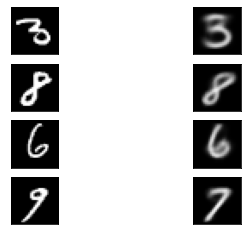

In [ ]:
def imshow(img):
    npimg = img.cpu().numpy()
    plt.imshow(npimg, vmin=0, vmax=1, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
_, x= next(enumerate(train_loader))
samples = x[0].to(device)[30:]
samples_rec,   _, _ = vae(samples)
samples_rec = samples_rec.detach().cpu().view(-1,28,28)
print("Original             Reconstructed")
for i in range(0, 4):
  plt.subplot(4,2,2*i+1)
  imshow(samples[i,0])
    
  plt.subplot(4, 2, 2*i+2)
  imshow(samples_rec[i])

The images are a bit blurred in comparison to the originals. Furthermore the nine is not reconstructed as a nine, but more as a seven. Also the three is different from the original, but still a three.

Your model should be able to generate images that look similar to the samples of the MNIST dataset.
* Run the code
* Describe what you see

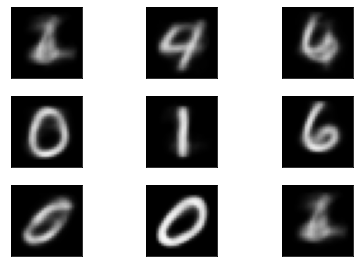

In [ ]:
for i in range(1, 10):
    plt.subplot(3,3,i)
    sample = vae.sampling(n=1).detach().view(-1,28,28).cpu()
    plt.tight_layout()
    imshow(sample[0])
    plt.xticks([])
    plt.yticks([])

The images are blurry. Some like the zeros, the one and the six look good, but others like the first or the last image aren't that great.

### Training a second VAE with larger latent space dimension
Note that the quality of the reconstruction will also depend on the dimension of the latent space. To explore this, train a second model called `vae2` and use it to reconstruct a few example digits to evaluate the change in quality. Comment on your findings.

In [ ]:
encoder_layer_sizes = [784, 512, 256]
decoder_layer_sizes = [256, 512, 784]

latent_dim = 16
vae2 = CVAE(inp_dim=784, encoder_layer_sizes=encoder_layer_sizes, decoder_layer_sizes=decoder_layer_sizes, latent_dim=latent_dim)
vae2 = vae2.to(device)
optimizer = optim.Adam(vae2.parameters(), lr=1e-3)

# Training of the VAE2
def train(epoch):
    vae2.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        x, y = data
        x = x.to(device)
        optimizer.zero_grad()

        recon_batch,  mu, log_var = vae2(x)
        loss = loss_function(recon_batch,  x, mu, log_var)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

epochs = 15
for epoch in range(epochs):
    train(epoch)

torch.save(vae2.state_dict(), "trained_vae2.pt")

Train Epoch: 0 [0/60000 (0%)]	Loss: 45.411308
Train Epoch: 0 [12800/60000 (21%)]	Loss: 12.451169
Train Epoch: 0 [25600/60000 (43%)]	Loss: 11.264641
Train Epoch: 0 [38400/60000 (64%)]	Loss: 9.059128
Train Epoch: 0 [51200/60000 (85%)]	Loss: 8.330046
====> Epoch: 0 Average loss: 0.1746
Train Epoch: 1 [0/60000 (0%)]	Loss: 7.309960
Train Epoch: 1 [12800/60000 (21%)]	Loss: 7.118285
Train Epoch: 1 [25600/60000 (43%)]	Loss: 6.857287
Train Epoch: 1 [38400/60000 (64%)]	Loss: 6.074942
Train Epoch: 1 [51200/60000 (85%)]	Loss: 5.818210
====> Epoch: 1 Average loss: 0.1044
Train Epoch: 2 [0/60000 (0%)]	Loss: 5.501448
Train Epoch: 2 [12800/60000 (21%)]	Loss: 5.664929
Train Epoch: 2 [25600/60000 (43%)]	Loss: 5.588057
Train Epoch: 2 [38400/60000 (64%)]	Loss: 5.133903
Train Epoch: 2 [51200/60000 (85%)]	Loss: 5.004089
====> Epoch: 2 Average loss: 0.0858
Train Epoch: 3 [0/60000 (0%)]	Loss: 4.890489
Train Epoch: 3 [12800/60000 (21%)]	Loss: 5.142298
Train Epoch: 3 [25600/60000 (43%)]	Loss: 5.214604
Train Epo

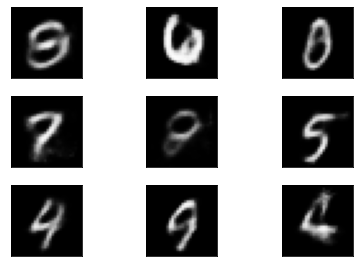

In [ ]:
for i in range(1, 10):
    plt.subplot(3,3,i)
    sample = vae2.sampling(n=1).detach().view(-1,28,28).cpu()
    plt.tight_layout()
    imshow(sample[0])
    plt.xticks([])
    plt.yticks([])

With increased latent space dimension ($dim(z) = 16$) the training loss is improved only slightly. Visibly, the reconstruction has slightly improved. The reconstruction of the 9 is more accurate.

Why is there already an answer given? Nevertheless, we were able to confirm that answer with our findings.

### Training CVAE
We optimize in the following the CVAE (simpy run the code).

In [ ]:
encoder_layer_sizes = [784, 512, 256]
decoder_layer_sizes = [256, 512, 784]
latent_dim = 2
cvae = CVAE(inp_dim=784, encoder_layer_sizes=encoder_layer_sizes, decoder_layer_sizes=decoder_layer_sizes, latent_dim=latent_dim, conditional=True )

cvae = cvae.to(device)
optimizer = optim.Adam(cvae.parameters())


def train(epoch):
    cvae.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        x, y = data
        x = x.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = cvae(x, y)
        loss = loss_function(recon_batch, x, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    
    
# Training of CVAE
for epoch in range(1, 15):
    train(epoch)

torch.save(cvae.state_dict(), "trained_cvae.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 45.429008
Train Epoch: 1 [12800/60000 (21%)]	Loss: 10.939700
Train Epoch: 1 [25600/60000 (43%)]	Loss: 10.179714
Train Epoch: 1 [38400/60000 (64%)]	Loss: 9.207643
Train Epoch: 1 [51200/60000 (85%)]	Loss: 9.928901
====> Epoch: 1 Average loss: 0.1738
Train Epoch: 2 [0/60000 (0%)]	Loss: 8.861543
Train Epoch: 2 [12800/60000 (21%)]	Loss: 8.940262
Train Epoch: 2 [25600/60000 (43%)]	Loss: 8.981797
Train Epoch: 2 [38400/60000 (64%)]	Loss: 8.571787
Train Epoch: 2 [51200/60000 (85%)]	Loss: 9.063435
====> Epoch: 2 Average loss: 0.1407
Train Epoch: 3 [0/60000 (0%)]	Loss: 8.165624
Train Epoch: 3 [12800/60000 (21%)]	Loss: 8.670670
Train Epoch: 3 [25600/60000 (43%)]	Loss: 8.707689
Train Epoch: 3 [38400/60000 (64%)]	Loss: 8.294723
Train Epoch: 3 [51200/60000 (85%)]	Loss: 8.728107
====> Epoch: 3 Average loss: 0.1356
Train Epoch: 4 [0/60000 (0%)]	Loss: 7.974030
Train Epoch: 4 [12800/60000 (21%)]	Loss: 8.368775
Train Epoch: 4 [25600/60000 (43%)]	Loss: 8.475484
Train Epo

### Sanity Check CVAE
Check whether your CVAE is able to reconstruct certain images when conditioned on the label (simply run the code).
* Is there a difference to the standard VAE?

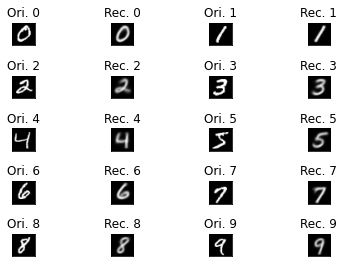

In [ ]:
x,l = next(iter(train_loader))
for i in range(0, 10):
    x_one_label = x[l==i][:2]

    samples = x_one_label[:1].to(device)
    labels= i* torch.ones(1).type(torch.long)
    plt.subplot(5,4,2*i+1)
    plt.tight_layout()
    imshow(samples[0,0].cpu())
    plt.title("Ori. {}".format(i))
    
    samples_rec, _, _ = cvae(samples, c = labels)
    samples_rec = samples_rec.detach().cpu().view(-1,28,28)

    plt.subplot(5, 4, 2*i+2)
    plt.tight_layout()
    imshow(samples_rec[0])
    plt.title("Rec. {}".format(i))

The results are way better than with the original VAE. The images are still a bit blurry, but every number was reconstructed quite good.

Check whether your CVAE is able to generate images from the MNIST dataset distribution by sampling from the latent space and decode these latent codes (simply run the code).
* How do the generated digits compare to those of the VAE?
* Can you imagine why differences could arise?

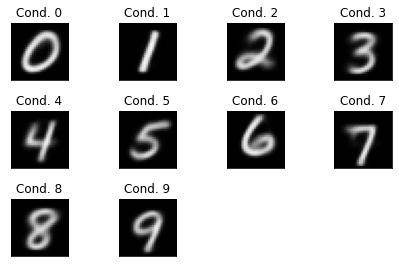

In [ ]:
for i in range(0, 10):
    plt.subplot(3,4,i+1)
    label = i* torch.ones(1).type(torch.long)
    sample = cvae.sampling(n=1, c=label).detach().view(-1,28,28).cpu()
    plt.tight_layout()
    imshow(sample[0])
    plt.xticks([])
    plt.yticks([])
    plt.title("Cond. {}".format(i))

The results look very good. Although, they are still a bit blurry.

The results may be better than with the normal VAE due to the additionally provided information (class label). This way, the CVAE can populate the complete latent space for each class and doesn't have to separate the distributions inside the latent space from one another, which results in border regions between classes (i.e. images that are a mixture of classes).

## Task 2: Visualisation of Latent Space of VAE


### Visualisation of output of decoder
Make sure you use the model vae trained with $2$ latent dimensions.

* Illustrate the 2 dimensional latent space by showing decoder output for different values in the latent space (see example on exercise sheet).

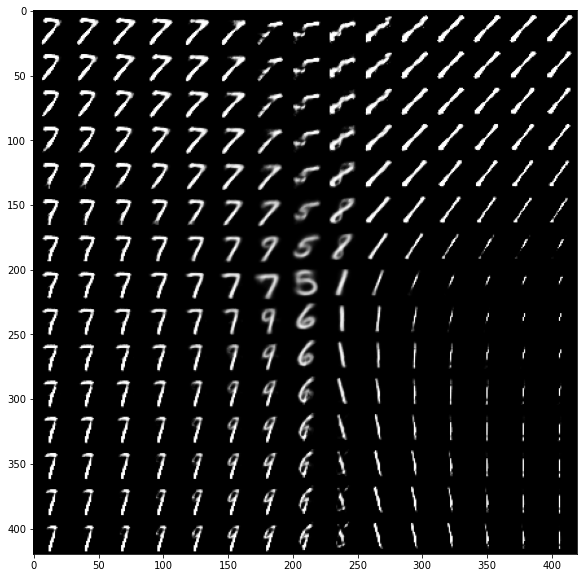

In [ ]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# We will sample n points within [-15, 15]
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        with torch.no_grad():
            z_sample = torch.tensor(np.array([[xi, yi]])).to(device).float()
            x_decoded = vae.decoder.forward(z_sample).cpu()
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
        j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.gray()
plt.imshow(figure)
plt.show()

### Visualisation of latent space
In the following, you should visualize the latent space directly.
* Make a scatter plot in latent space, where each plotted point represents the latent code of a single image from the MNIST dataset. Color the points according to the image label.
* What kind of shape should ideally arise?
* What do you see in reality?

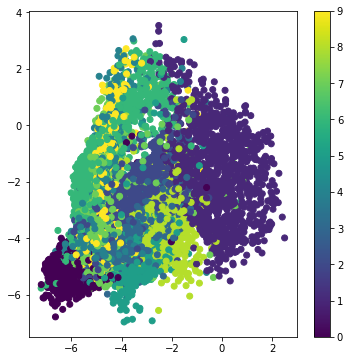

In [ ]:
plt.figure(figsize=(6, 6))

vae.eval()

for x_test, y_test in test_loader:
    with torch.no_grad():
        x_test = x_test.to(device)
        x_test_encoded_mu, x_test_encoded_log_var = vae.encoder.forward(x_test.view(-1, 784))
        code = x_test_encoded_mu + x_test_encoded_log_var
    plt.scatter(code.cpu()[:, 0], code.cpu()[:, 1], c=y_test, cmap="viridis")

plt.colorbar()
plt.show()

### Weaknesses of the VAE
* Find from your plot coordinates in the latent space that might cause problems to the VAE if you decode this points. Explain your reasoning.
* Illustrate the decoding of one of these points.
* Describe what you see.

We already did this above in our illustration of the sampled images. There we sampled the code from -15 to 15. As we can see now, our encoder never saw values that 'big' (usually only values between -7 and 4 and already there we have empty spots). Therefore we already have images that are not really a number like the images on the bottom right.

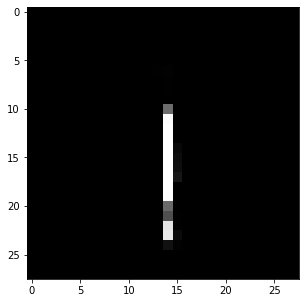

In [ ]:
with torch.no_grad():
    z_sample = torch.tensor(np.array([[15, 15]])).to(device).float()
    x_decoded = vae.decoder.forward(z_sample).cpu()
digit = x_decoded[0].reshape(digit_size, digit_size)

plt.figure(figsize=(5, 5))
plt.gray()
plt.imshow(digit)
plt.show()

## Task 3: Visualisation of Latent Space of CVAE

Make sure you use the model cvae trained with $2$ latent dimensions.

### Visualisation of Latent Space via Decoder

Repeat task 2 for the CVAE: 
* Illustrate the 2 dimensional latent space by showing the output of the decoder for different values in the latent space (see example on exercise sheet).
* Make two or three of these plots, each conditioned on a fixed label.

In [ ]:
def plot_sampled_images(class_num):
    n = 15  # figure with 15x15 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))

    class_num = torch.tensor(class_num).view(1, -1).to(device)

    # We will sample n points within [-15, 15]
    grid_x = np.linspace(-6, 6, n)
    grid_y = np.linspace(-6, 6, n)

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            with torch.no_grad():
                z_sample = torch.tensor(np.array([[xi, yi]])).to(device).float()
                x_decoded = cvae.decoder.forward(z_sample, c=class_num).cpu()
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.gray()
    plt.imshow(figure)
    plt.show()

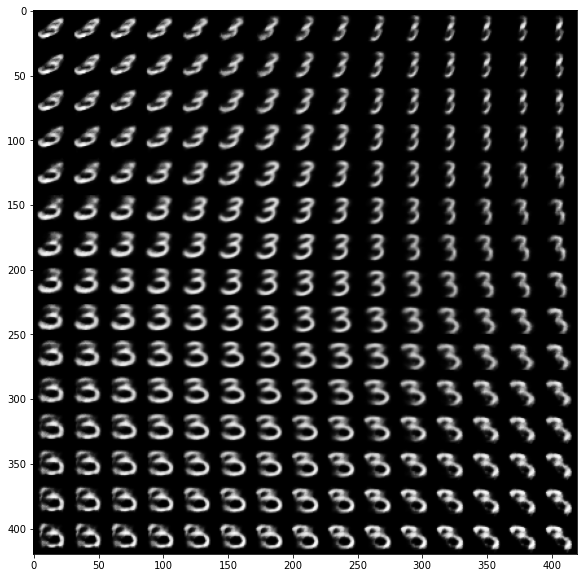

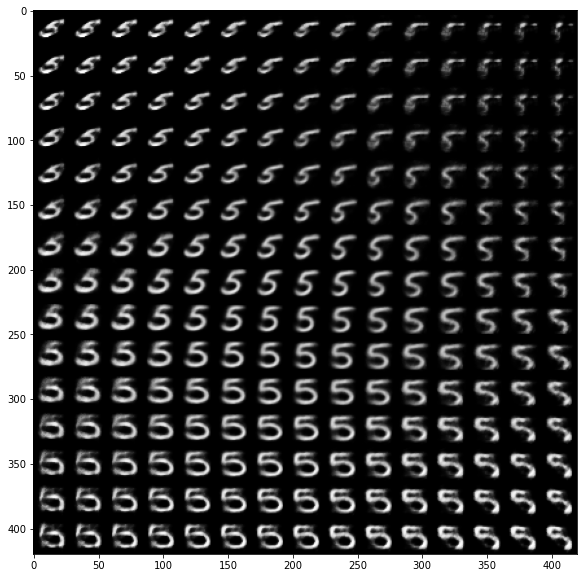

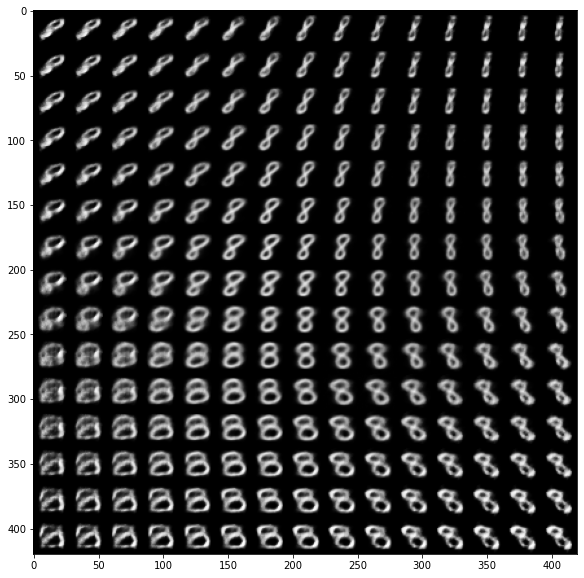

In [ ]:
plot_sampled_images(3)
plot_sampled_images(5)
plot_sampled_images(8)

### Visualisation of Latent Space via Decoder
* Repeat the scatter plot from Task 2. For each sample, use the correct label as the condition. Color the points according to the label.
* What difference do you see, compared to the standard VAE?
* How to you explain this?
* What does this mean for 'bad samples', as observed in Task 2?


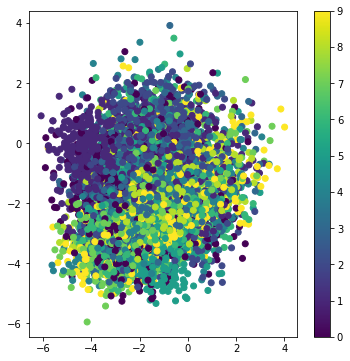

In [ ]:
plt.figure(figsize=(6, 6))

vae.eval()

for x_test, y_test in test_loader:
    with torch.no_grad():
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        x_test_encoded_mu, x_test_encoded_log_var = cvae.encoder.forward(x_test.view(-1, 784), y_test)
        code = x_test_encoded_mu + x_test_encoded_log_var
    plt.scatter(code.cpu()[:, 0], code.cpu()[:, 1], c=y_test, cmap="viridis")

plt.colorbar()
plt.show()

Other than with the normal VAE here the classes are not separable from each other in the latent space. This is due to the extra information (class label) we provide. This way the CVAE can use the whole latent space for each class.

Regarding the bad samples, we still have a similar problem as with the VAE, as the CVAE only learned a Gaussian distribution for the training data and therefore has empty border regions of this Gaussian. However, as each class can use the whole latent space, the classes don't have to be separable as for the VAE, where holes can also occur somewhere in the middle between classes.

## Task 4: Generative Classifier
We define our classifier as maximum a posteriori estimator and expand according to Bayes rule. The label $\hat y$ for a given ..$x$ is predicted according to:

$$ \hat y= \arg \max_y p(y \mid x) = \arg \max_y \frac{p(x \mid y)p(y)}{p(x)} = \arg \max_y \log p(x \mid y) \ ,$$

where the last identity makes use of the fact that $p(y)=1/10$ is constant for all MNIST labels. We can approximate $\log p(x \mid y)$ in the following way: Given an input image, run the CVAE 10 times, each time conditioning one one of the different class labels $y$. Calculate the losses for each case and use them to design a classifier. Note that the network was never trained as a classifier, but is still able to perform the task.

In [ ]:
class CVAEClassifier(torch.nn.Module):
    def __init__(self, cvae: CVAE, num_classes: int = 10):
        super(CVAEClassifier, self).__init__()

        self.cvae = cvae
        self.cvae.eval()

        self.num_classes = num_classes

    def forward(self, x):
        errors_per_element = []

        for element in x:
            error_per_class = []

            for label_num in range(self.num_classes):
                with torch.no_grad():
                    label_num = torch.tensor(label_num, dtype=torch.int64).view(-1, 1)
                    recon_element, code_means, code_log_vars = self.cvae.forward(element, label_num)
                error_per_class.append(loss_function(recon_element, element, code_means, code_log_vars).cpu())

            errors_per_element.append(error_per_class)

        return torch.argmin(torch.tensor(errors_per_element), dim=1)

In [ ]:
cvae_classifier = CVAEClassifier(cvae)

num_of_wrong_predictions = 0

for x_test, y_test in test_loader:
    y_pred = cvae_classifier.forward(x_test)
    num_of_wrong_predictions += torch.sum(y_test != y_pred)

print("Error rate:", num_of_wrong_predictions.item() / len(test_dataset))

Error rate: 0.0785
